In [2]:
import matplotlib.pyplot as plt
import pylab
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from hopfield import HopfieldNetwork
    

# plt.rcParams.update({'lines.markeredgewidth': 1})
sns.set(palette='Dark2')
sns.set_context('paper' , font_scale=1.0)
pylab.rcParams['figure.dpi'] = 300

nn = HopfieldNetwork()

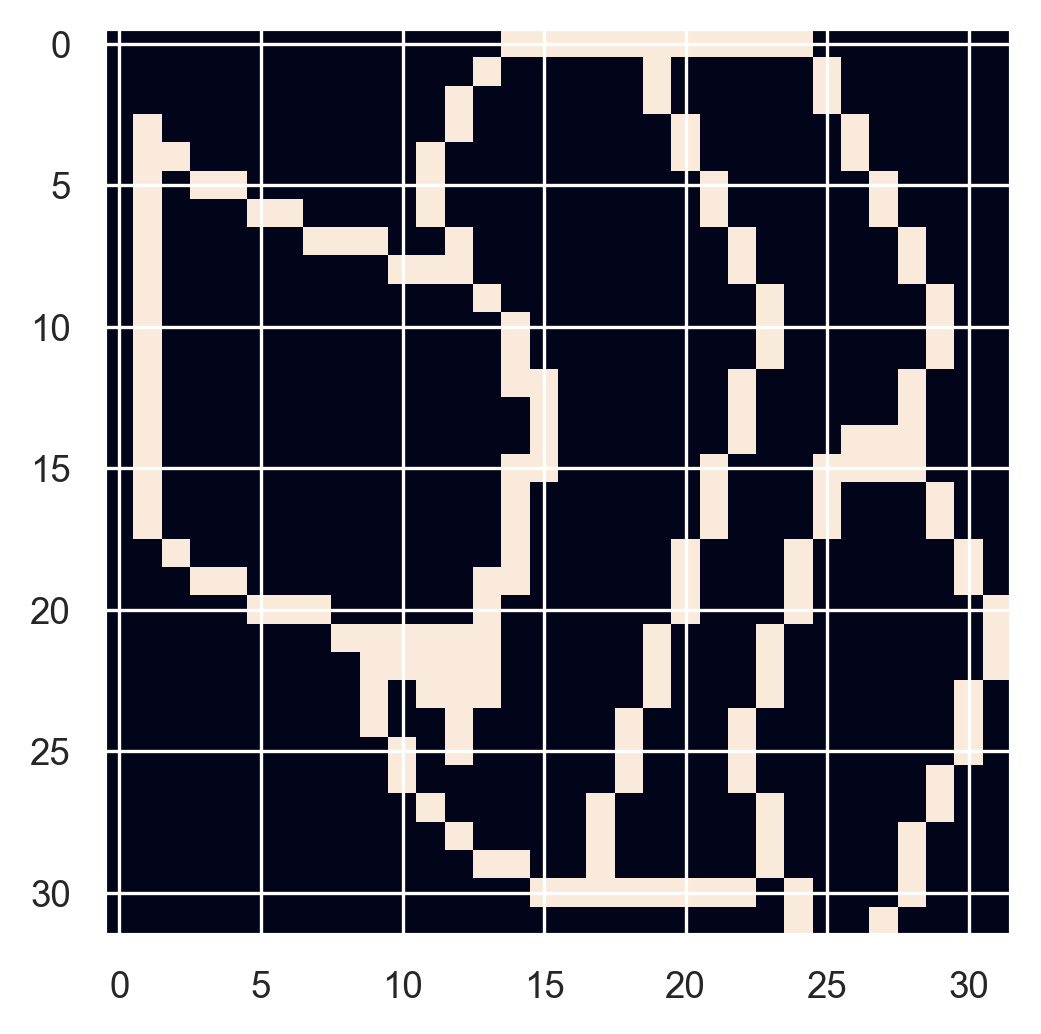

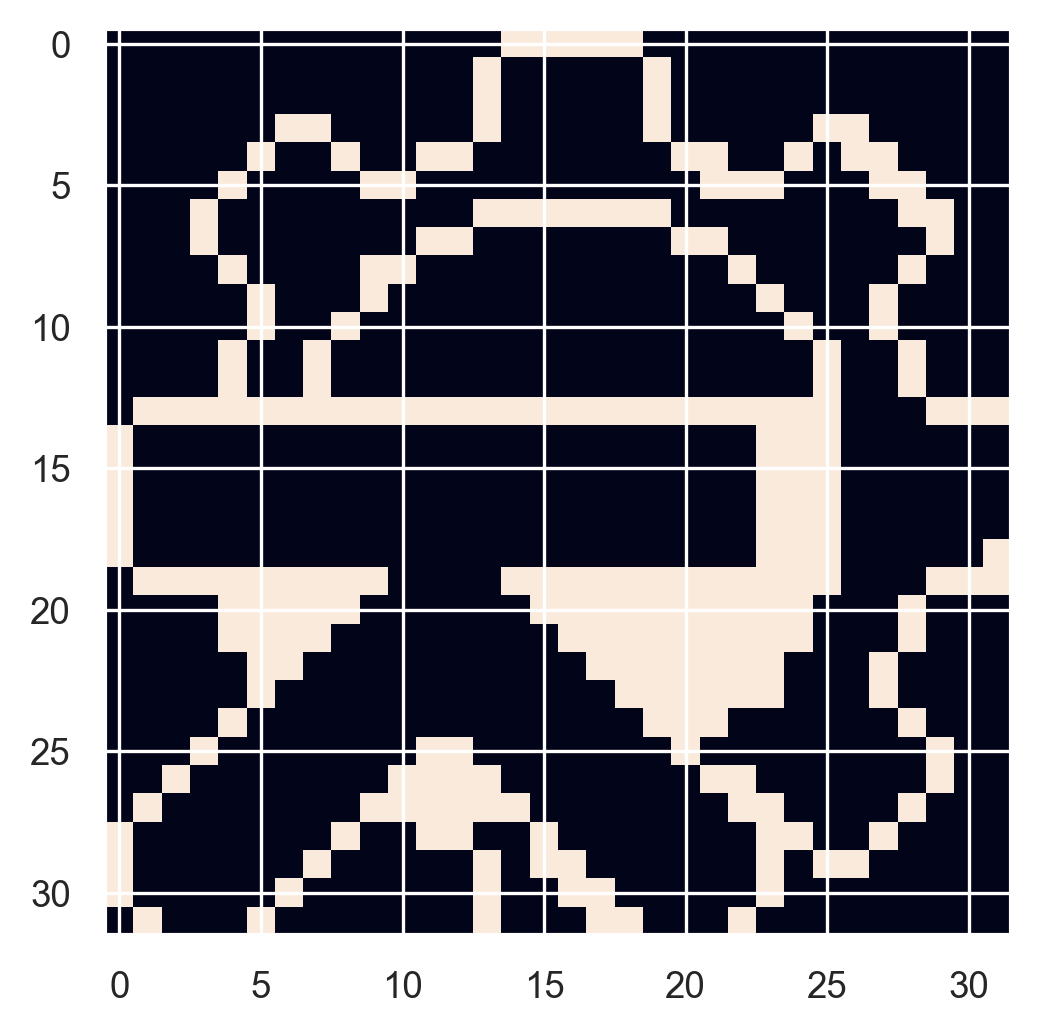

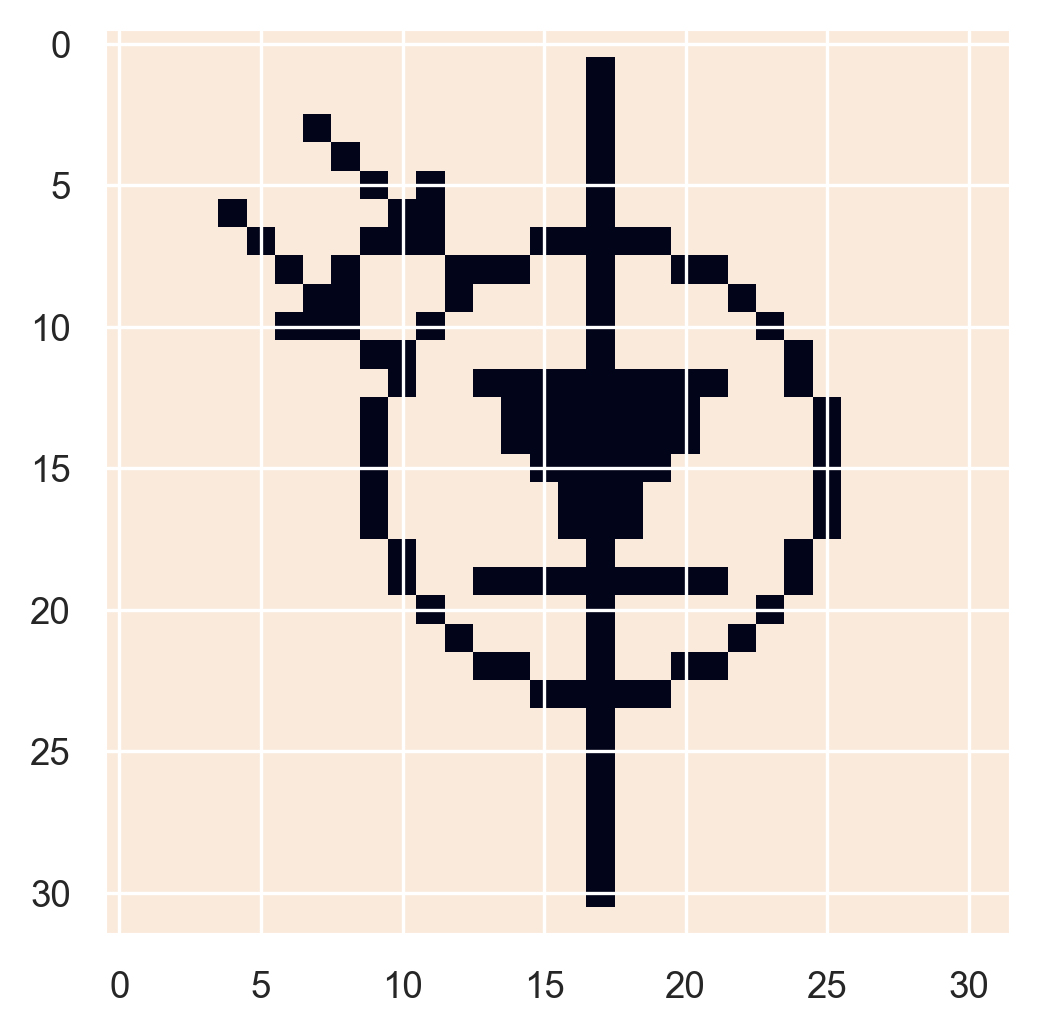

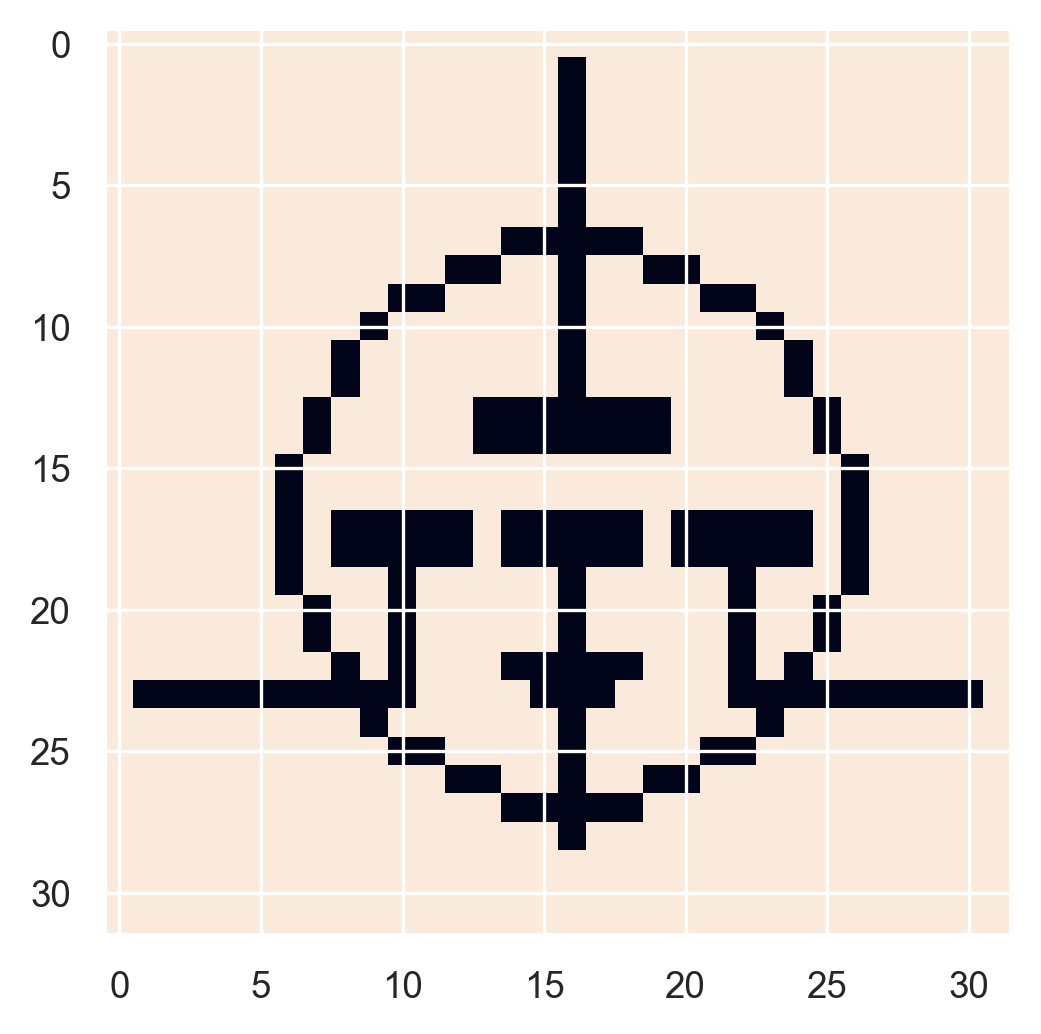

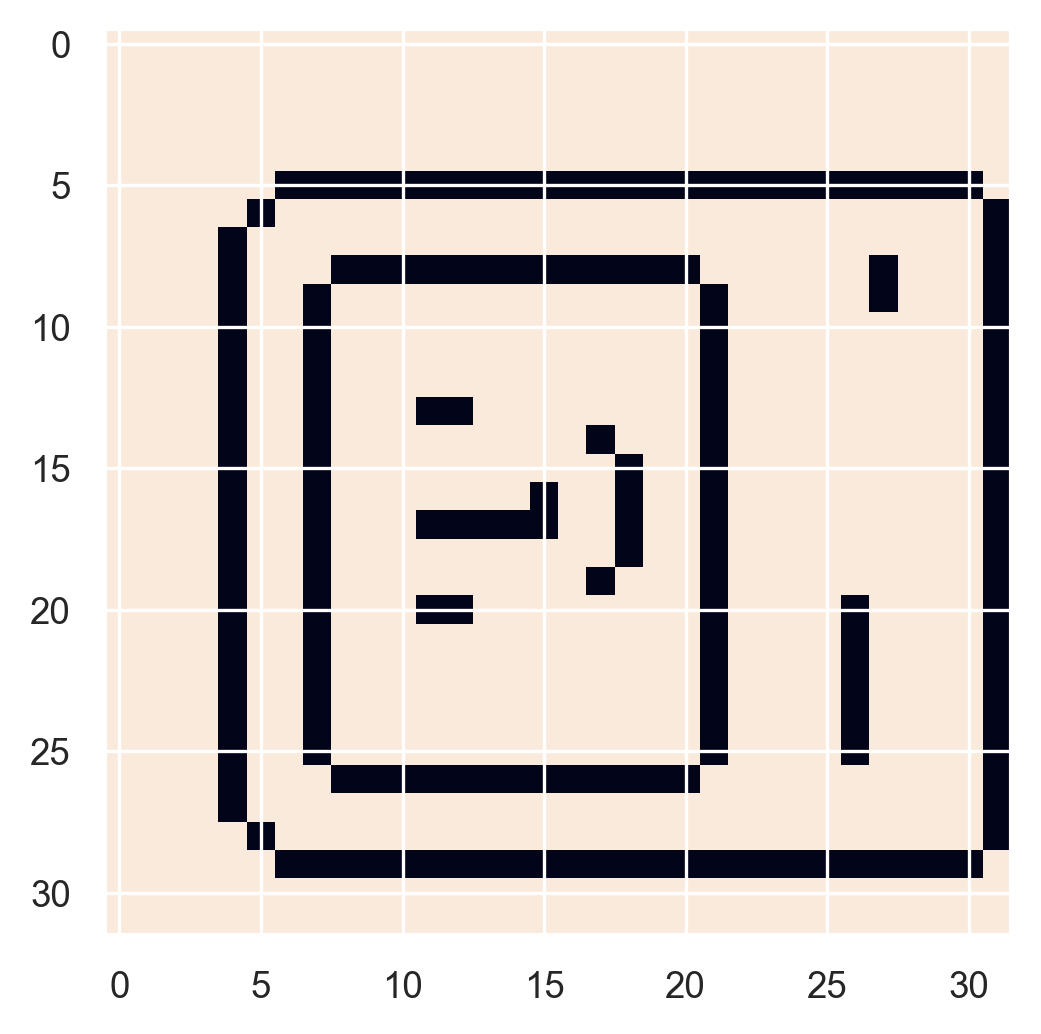

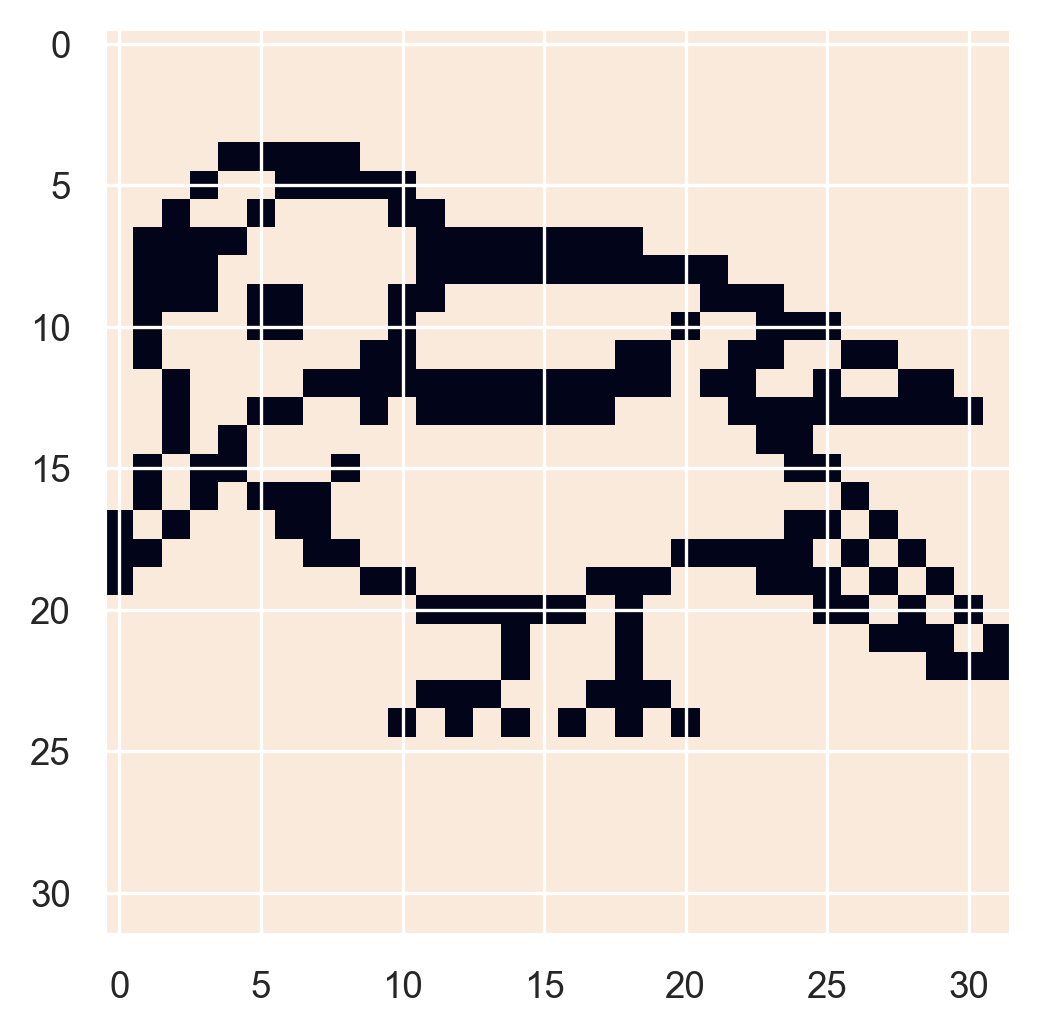

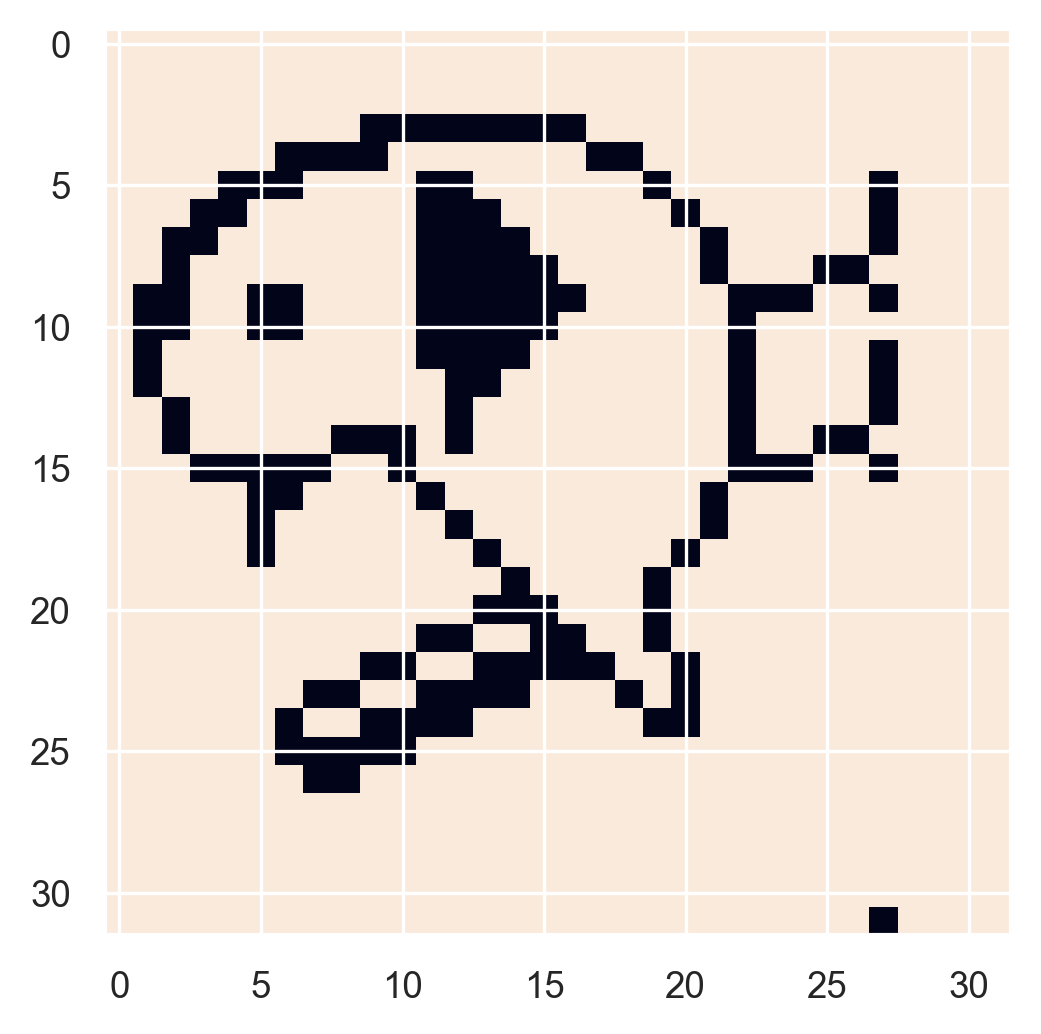

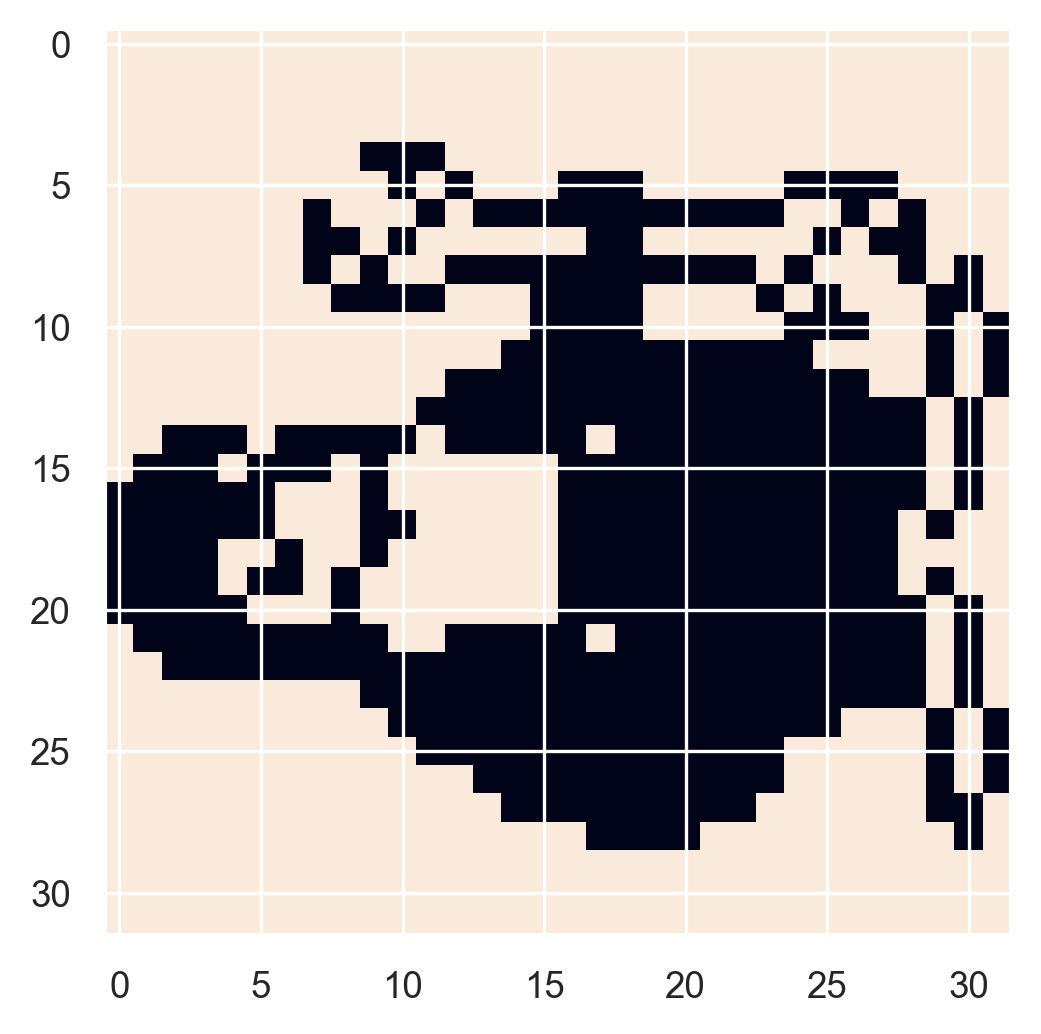

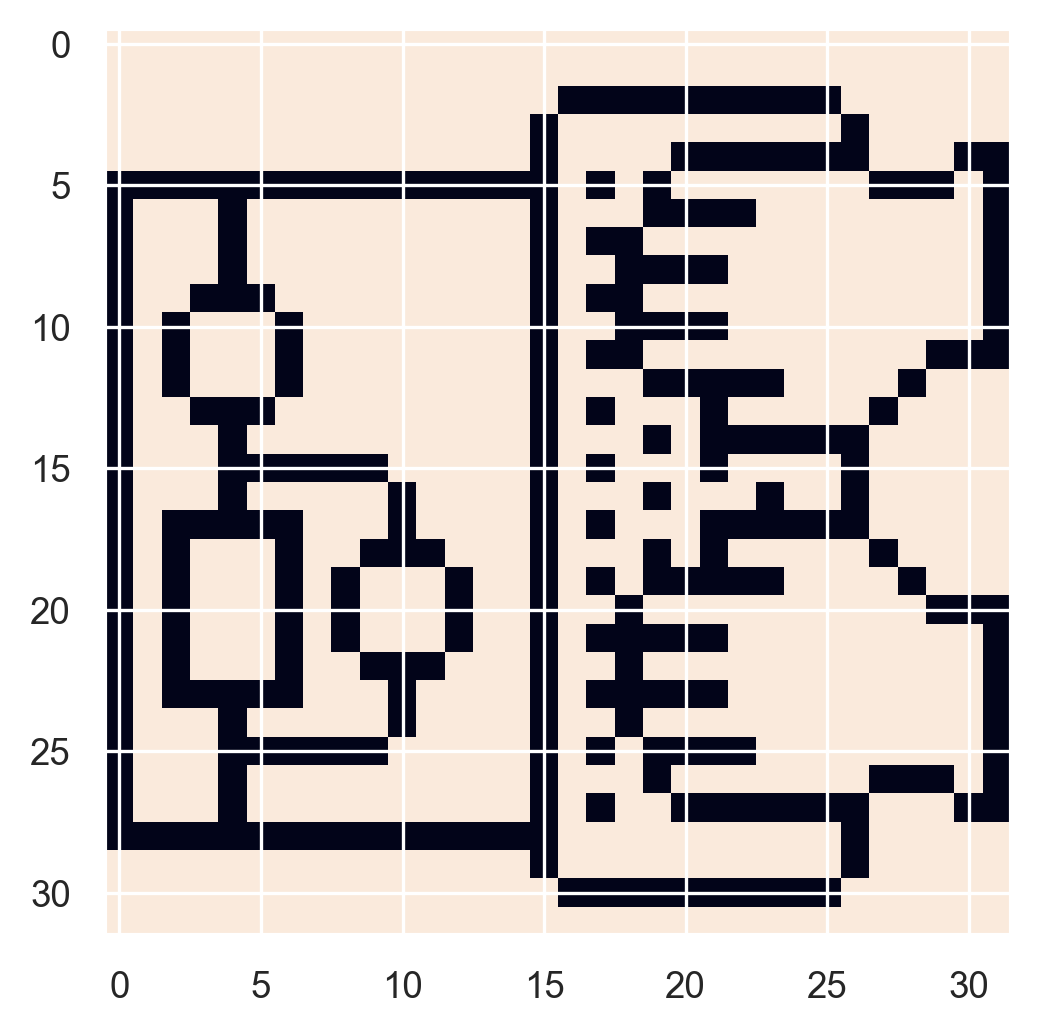

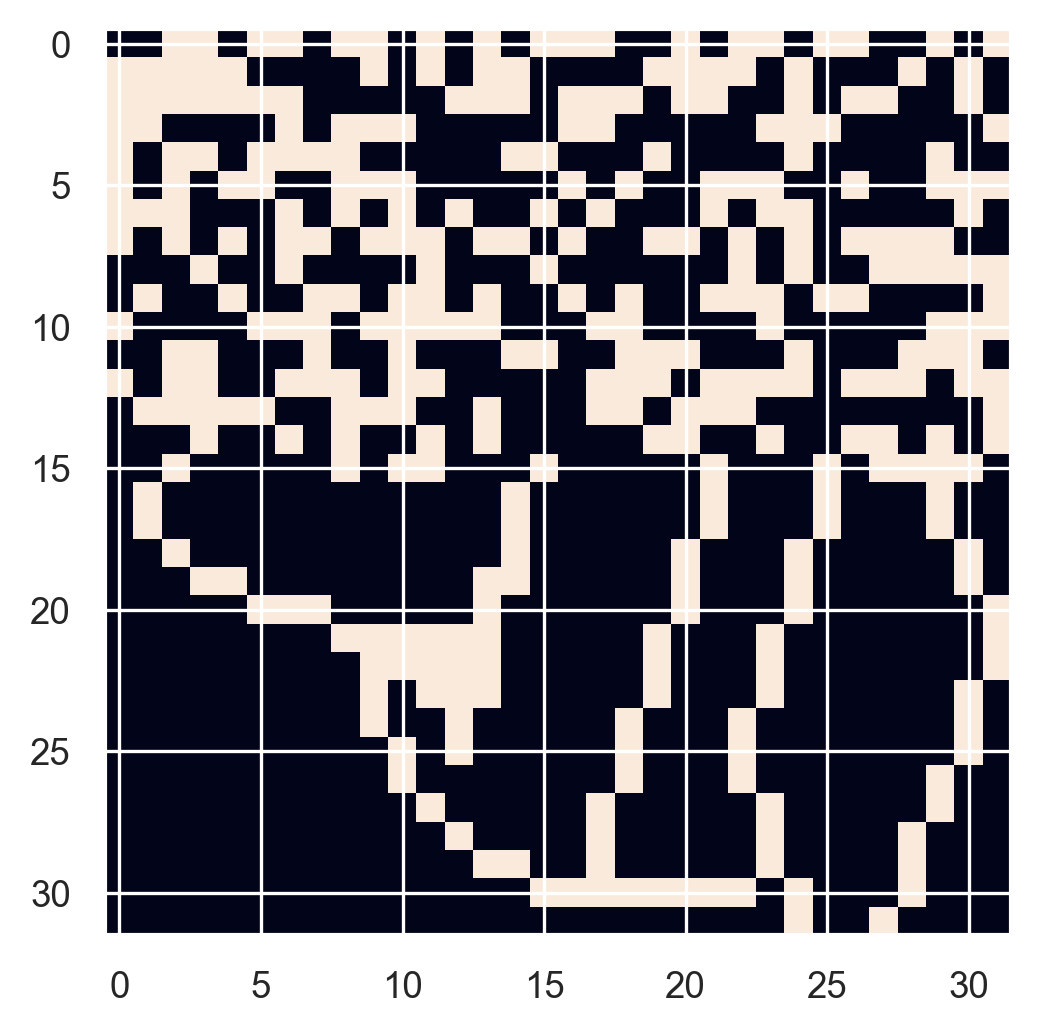

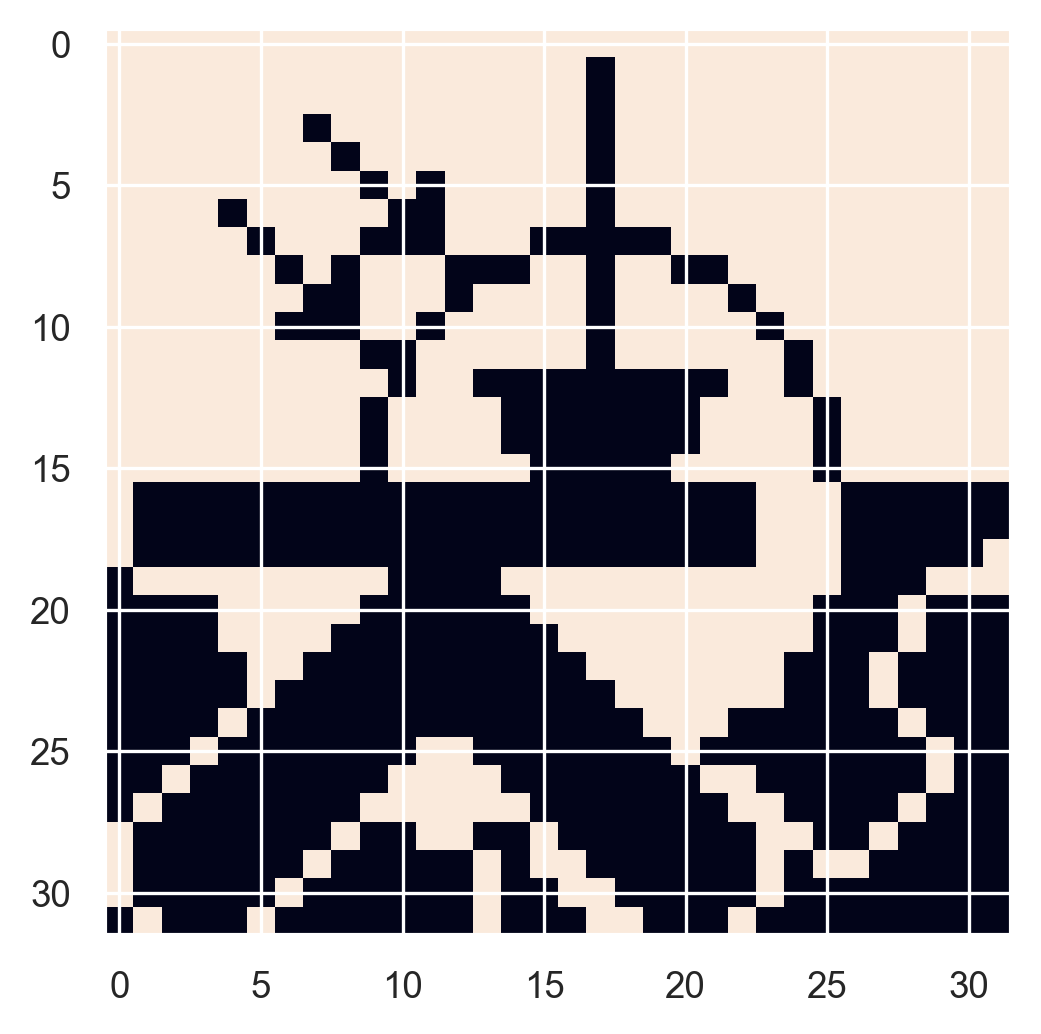

In [13]:
# load data
patterns = np.loadtxt('pict.dat', delimiter=',', dtype='int32').reshape((11, 1024))
for pattern in patterns:
    p = pattern.copy().reshape((32, 32))
    fig, ax = plt.subplots()
    ax.imshow(p)
    plt.show()

In [18]:
nn.train(patterns[:3, :])

# make sure patterns are stable
Xp = nn.recall(patterns[:3, :])
assert np.all(Xp == patterns[:3, :])
print(Xp == patterns[:3, :])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
